# HRRR Probability Distribution Function (PDF) at a Point for the Year
Show the estimated PDF at a single point (perceniltes of a percentile)

In [4]:
%matplotlib inline

import h5py
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import multiprocessing

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [6, 4]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .1
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_data.grid_manager import pluck_point_new
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict

from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b %d\n%H:%M')

In [5]:
# Station and Variable of Interest
stn = 'HWKC1'
var = 'TMP:2 m'

# MesoWest Station Info
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']

# Directory of percentile files
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

In [6]:
# Load HRRR lat/lon Grid
latlon_file = h5py.File('/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [7]:
# Pluck point nearest MesoWest location
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

print lat[x,y], MWlat, 'and',lon[x,y], MWlon

38.73599 38.735086 and -122.83093 -122.837058


In [8]:
# list of available percentiles in the OSG output files
percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

### Function: Get the percentiles at a single point. 
Must have variable, directory, x, and y already defined.

In [9]:
def get_point_percentiles(DATE):
    ## PP stands for Percentiles Point
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
    PP = np.array([])
    with h5py.File(DIR+FILE, 'r') as f:
        for i in percentiles:
            PP = np.append(PP, f["p%02d" % i][x][y])

    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        PP -= 273.15
    
    return PP

## Single hour

In [127]:
PP = get_point_percentiles(datetime(2017, 6, 1))

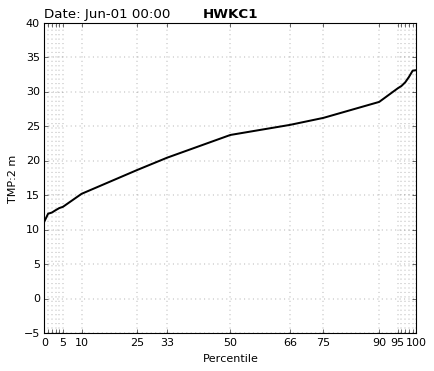

In [132]:
# Plot Percentile Curve
plt.plot(percentiles, PP, color='k')

plt.grid()

plt.xlabel('Percentile')
tick_labels = [0,'','','','',5, 10, 25, 33, 50, 66, 75, 90, 95, '', '', '','',100]
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel(var)
plt.ylim([-5,40])

plt.title('Date: %s' % DATE.strftime('%b-%d %H:%M'), loc='Left')
plt.title('%s' % (stn), loc='Center', fontweight='bold')
SAVEDIR = '/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR/OSG/stn_percentiles_all_year/'
plt.savefig(SAVEDIR+'%s_%s_singlehour' % (stn.upper(), variable))

## All hours

In [11]:
# all hours including leap year
DATES = [datetime(2016, 1, 1)+timedelta(hours=h) for h in range(366*24+1)]

In [124]:
# Get the Data
Ncpu = multiprocessing.cpu_count()
p = multiprocessing.Pool(Ncpu)
PP = p.map(get_point_percentiles,DATES)
p.close()

In [125]:
# Calculate the Percentiles of the Percentiles (0th percentile of all the 0th percentiles, etc.)
percentiles_PP = np.percentile(PP, [0,5,25,50,75,95,100], axis=0)

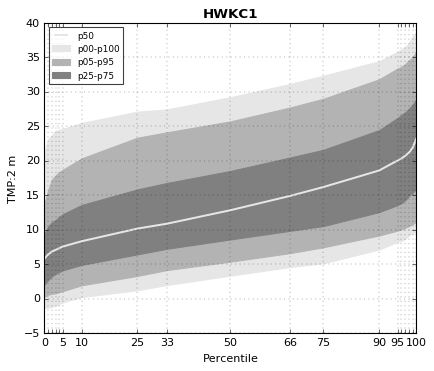

In [126]:
# Plot
plt.fill_between(percentiles, percentiles_PP[0], percentiles_PP[-1], color=[.9,.9,.9], label='p00-p100')
plt.fill_between(percentiles, percentiles_PP[1], percentiles_PP[-2], color=[.7,.7,.7], label='p05-p95')
plt.fill_between(percentiles, percentiles_PP[2], percentiles_PP[-3], color=[.5,.5,.5], label='p25-p75')
plt.plot(percentiles, percentiles_PP[3], color=[.9,.9,.9], label='p50')

plt.grid()
plt.legend(loc=2)

plt.xlabel('Percentile')
tick_labels = [0,'','','','',5, 10, 25, 33, 50, 66, 75, 90, 95, '', '', '','',100]
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel(var)

plt.title('%s' % (stn), loc='Center', fontweight='bold')

SAVEDIR = '/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR/OSG/stn_percentiles_all_year/'
plt.savefig(SAVEDIR+'%s_%s' % (stn.upper(), variable))

In [ ]:
timer = datetime.now()
a = map(get_point_percentiles,DATES[0:3000])
print datetime.now()-timer

In [17]:
timer = datetime.now()
Ncpu = multiprocessing.cpu_count()
p = multiprocessing.Pool(Ncpu)
PP = p.map(get_point_percentiles,DATES[0:3000])
p.close()
print datetime.now()-timer

0:04:49.946539
